In [1]:
from variability import calculate_indicators
from ti_mask_generation import gen_ti_frame_squares
from utils import load_pickle_file
from display_functions import plot_realizations
import geone as gn
import pickle
import matplotlib.pyplot as plt
from sklearn import manifold
from matplotlib import cm
from matplotlib.lines import Line2D
import numpy as np
import zipfile
import csv
import ast
import numpy as np
import os
import glob
from itertools import product


In [2]:
SEED_LIST=[852,123,456,789,254,
           #648,675,585,654,157
           ]
TI_PCT_AREA_LIST=[25,
                  55,
                  #75,
                  90]
NUM_SHAPE_LIST=[#1,
                5,
                10,
                15,
                50]
AUX_VARS_LIST=[
    "grid_grv",
    "grid_lmp",
    "grid_mag",
    "grid_grv,grid_lmp",
    "grid_grv,grid_mag",
    "grid_lmp,grid_mag",
    # "grid_grv,grid_lmp,grid_mag",
]

# THE CELLS BELOW ARE FOR DISPLAYING THE IMAGES

In [3]:
def find_all_simulation_folders(ti_pct, num_shape, ti_aux_var, combinations_dict=None,
                                seed=None, zip_path=r'K:\CET\Resultats\results.zip', output_dir=None):
    norm = lambda s: s.strip().lower()
    aux_set = {norm(x) for x in ti_aux_var.split(",")}
    result = {}

    seed_filter = set(map(int, seed)) if seed is not None else (
        set(int(v["seed"]) for v in combinations_dict.values()) if combinations_dict else None
    )

    def parse_folder(folder):
        # output_mps_clf_{ti_pct}_{aux_vars}_{seed}/
        name = folder.strip('/').split('/')[-1]
        if not name.startswith('output_mps_clf_'):
            return None
        parts = name[len('output_mps_clf_'):].rsplit('_', 1)
        if len(parts) != 2:
            return None
        left, seed_str = parts
        try:
            seed_val = int(seed_str)
        except ValueError:
            return None
        sub = left.split('_', 1)
        if len(sub) != 2:
            return None
        ti_pct_str, aux_vars_str = sub
        try:
            ti_pct_val = int(ti_pct_str)
        except ValueError:
            return None
        return ti_pct_val, aux_vars_str, seed_val

    import zipfile, csv, ast
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        folders = [f for f in zipf.namelist() if f.startswith('output_mps_clf_') and f.endswith('/')]
        for folder in folders:
            parsed = parse_folder(folder)
            if not parsed:
                continue
            ti_pct_in_folder, aux_vars_in_folder, seed_in_folder = parsed

            if seed_filter is not None and seed_in_folder not in seed_filter:
                continue

            log_path = folder + 'deesse_output/simulation_log.csv'
            try:
                with zipf.open(log_path) as log_file:
                    reader = csv.DictReader((line.decode('utf-8') for line in log_file))
                    for row in reader:
                        try:
                            row_aux_set = {norm(x) for x in ast.literal_eval(row['auxTI_var'])}
                        except Exception:
                            continue

                        if (int(row['ti_pct_area']) == int(ti_pct)
                            and int(row['ti_nshapes']) == int(num_shape)
                            and row_aux_set == aux_set
                            and {norm(x) for x in aux_vars_in_folder.split(',')} == aux_set):
                            if combinations_dict:
                                for idx, combo in combinations_dict.items():
                                    if (int(combo['seed']) == seed_in_folder
                                        and int(combo['ti_pct_area']) == int(ti_pct)
                                        and int(combo['num_shape']) == int(num_shape)
                                        and {norm(x) for x in str(combo['aux_vars']).split(',')} == aux_set):
                                        result[idx] = folder
                                        break
                            else:
                                result[seed_in_folder] = folder
                            break
            except KeyError:
                continue
    return result

In [9]:
combinations_dict = {
    i: {"seed": s, "ti_pct_area": t, "num_shape": n, "aux_vars": a}
    for i, (s, t, n, a) in enumerate(
        product(SEED_LIST, TI_PCT_AREA_LIST+[75], NUM_SHAPE_LIST+[1], AUX_VARS_LIST+["grid_grv,grid_lmp,grid_mag"]), 
        1
    )
}

In [5]:
all_folders= {}
for ti_pct_i in TI_PCT_AREA_LIST+[75]:
    for num_shape_i in NUM_SHAPE_LIST+[1]:
        for ti_aux_var_i in AUX_VARS_LIST+["grid_grv,grid_lmp,grid_mag"]:
            folders = find_all_simulation_folders(
                                ti_pct=ti_pct_i,
                                num_shape=num_shape_i,
                                ti_aux_var=ti_aux_var_i,
                                seed=[852,123,456,789,254],
                                combinations_dict = combinations_dict
                            )
            all_folders |= folders
            

### The cell below is for displaying the TIs wih their mask.

123 25 5


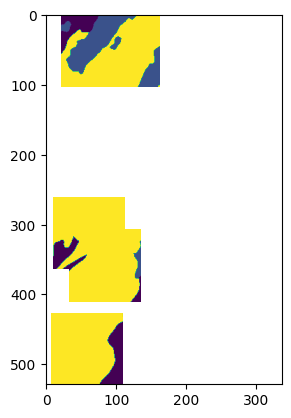

In [26]:
image = np.load(r"..\data\grid_geo.npy")
for (key, item) in all_folders.items():
    ti_frame, need_to_cut = gen_ti_frame_squares(529,337, 
                                                 ti_pct_area = combinations_dict[key]['ti_pct_area'], 
                                                 ti_nsquares = combinations_dict[key]['num_shape'], 
                                                 seed = combinations_dict[key]['seed'])
    masked_ti = np.ma.masked_array(image, mask = ~(ti_frame[0].astype(bool)))
    plt.imshow(masked_ti)
    print(combinations_dict[key]['seed'],combinations_dict[key]['ti_pct_area'],combinations_dict[key]['num_shape'])
    break


### The cell below is for displaying the Simulated Images.

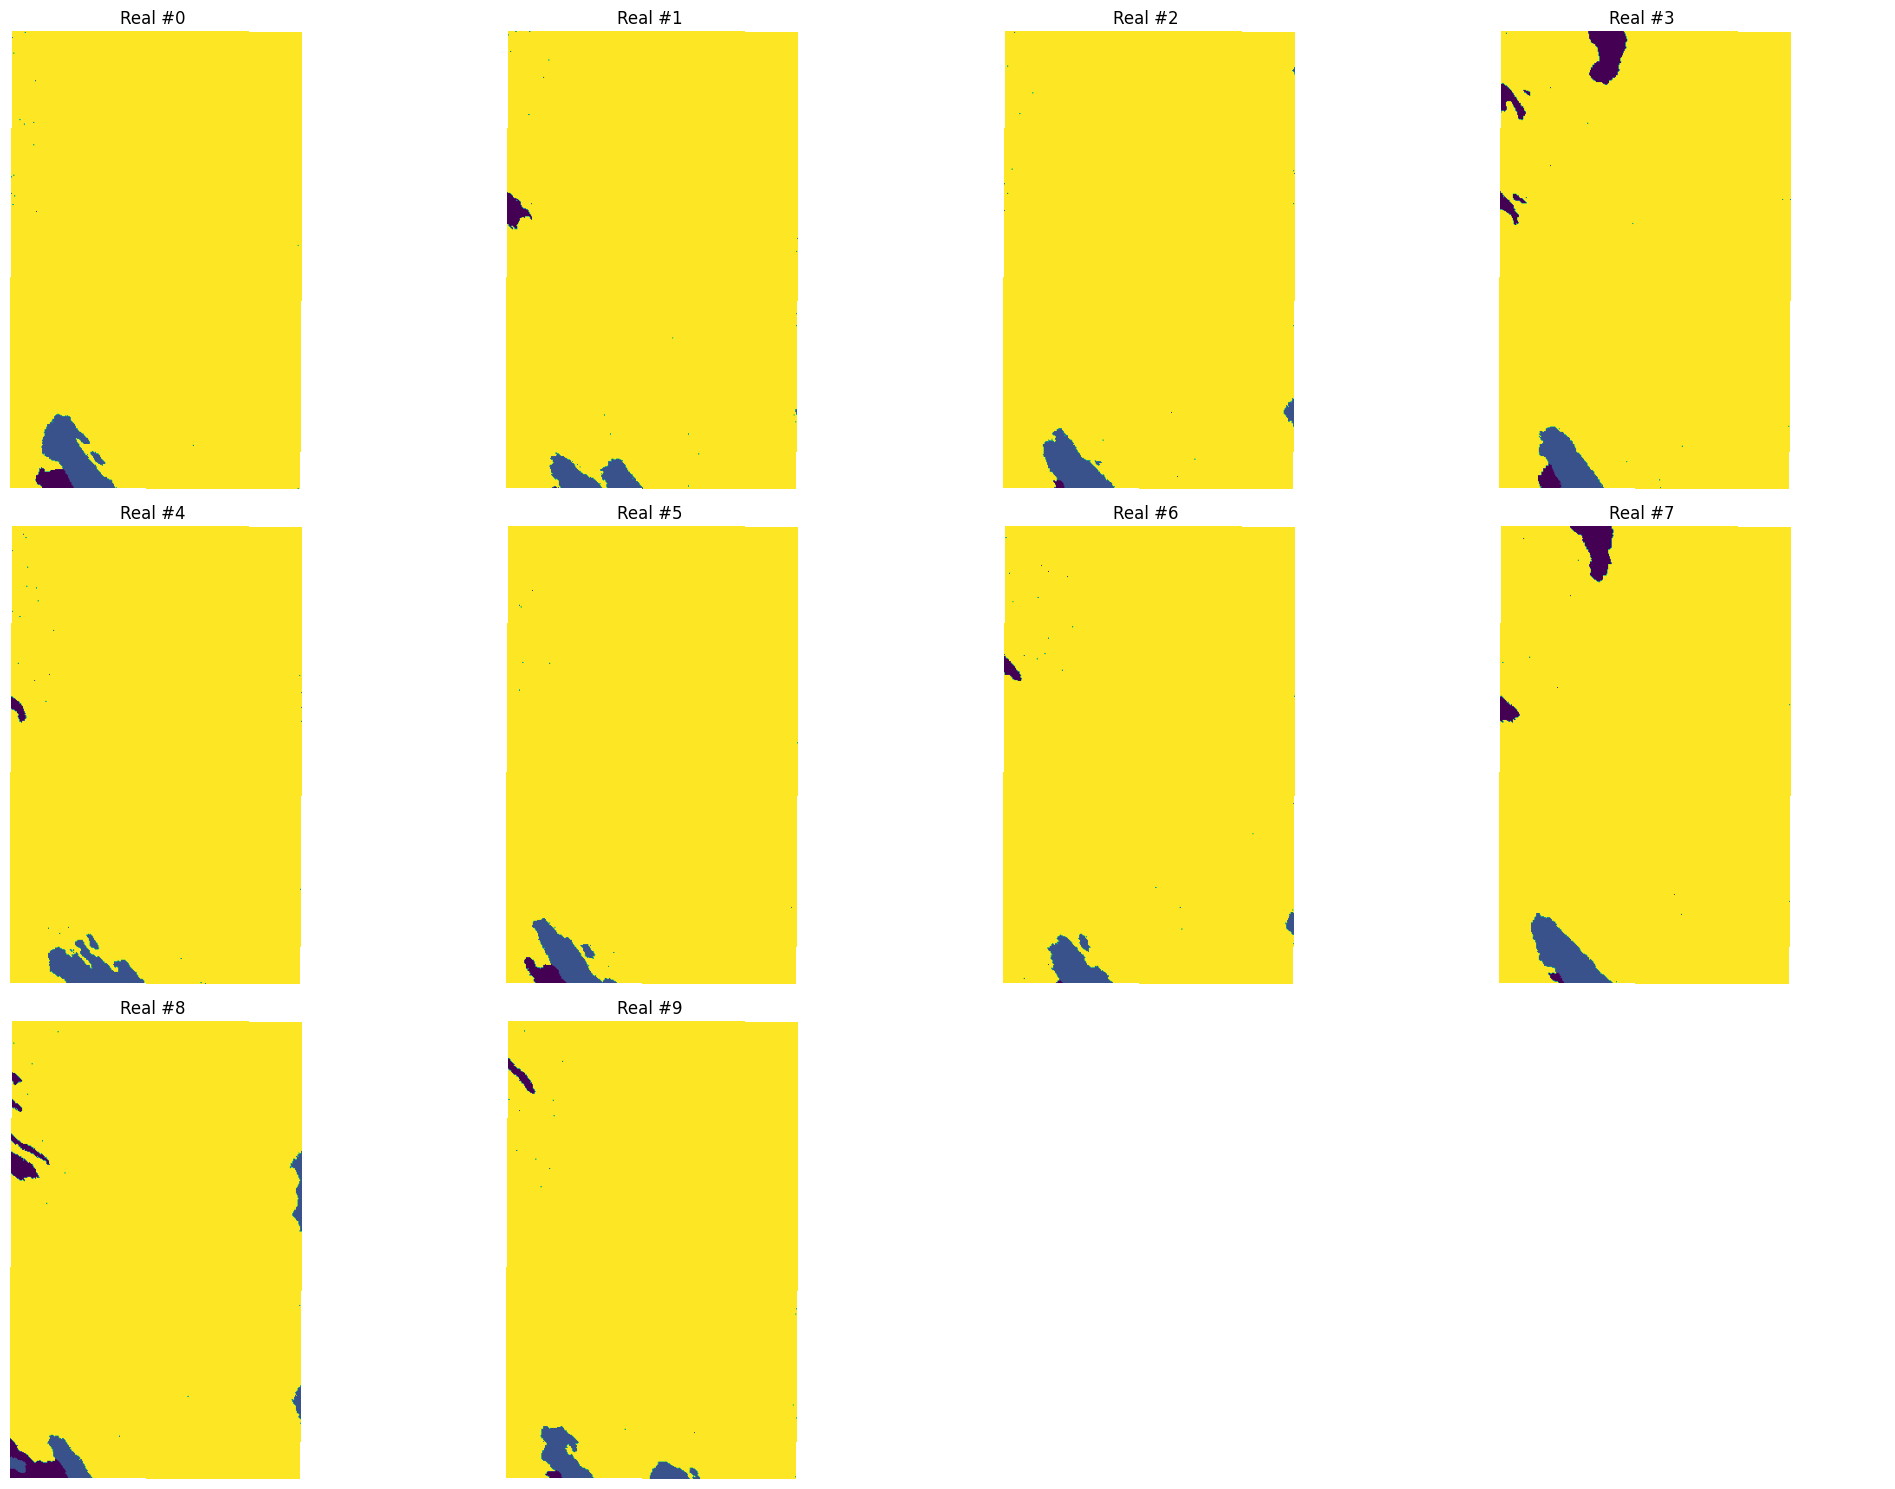

output_mps_clf_145_grid_grv_123/


In [11]:
with zipfile.ZipFile(r"K:\CET\Resultats\results.zip") as zip:
    for (key, item) in all_folders.items():
        deesse_output = pickle.load(zip.open(item + 'deesse_output/deesse_output.pkl', mode='r'))
        plot_realizations(deesse_output, n_real=10, show=True)
        print(item)
        break

In [ ]:
deesse_input = gn.deesseinterface.DeesseInput(
    nx=337, ny=529, nz=1,
    sx=1, sy=1, sz=1,
    ox=0, oy=0, oz=0,
    nv=2, varname=[['grid_geo', 'grid_grv'],['grid_geo', 'grid_grv']],
    TI=ti_list,
    #pdfTI = pdf_ti,
    mask=simgrid_mask,
    dataImage=cd_list,
    distanceType=distance_types,
    nneighboringNode=nvar*[nn],
    distanceThreshold=nvar*[dt],
    maxScanFraction=nTI*[ms],
    outputVarFlag=outputFlag,
    expMax= expMax,
    npostProcessingPathMax=1,
    seed=seed,
    nrealization=numberofmpsrealizations
) 

# THE CELLS BELOW ARE FOR DISPLAYING THE ANALYSIS OF THE RESULTS

In [ ]:
def find_all_simulation_folders(ti_pct, num_shape, ti_aux_var, seed=[852,123,456,789,254,648], zip_path=r'K:\CET\Resultats\results.zip', output_dir=None):
    aux_var_str = ",".join(sorted(ti_aux_var.split(",")))  # Normalise les variables
    matched_folders = []

    seeds = [str(sd) for sd in seed]

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        # Tous les dossiers output_mps_clf_
        folders = [f for sd in seeds for f in zipf.namelist() if f.startswith('output_mps_clf_') and f.endswith(sd + '/')]

        for folder in folders:
            log_path = folder + 'deesse_output/simulation_log.csv'
            try:
                with zipf.open(log_path) as log_file:
                    reader = csv.DictReader((line.decode('utf-8') for line in log_file))
                    for row in reader:
                        try:
                            row_aux_list = sorted(ast.literal_eval(row['auxTI_var']))
                            input_aux_list = sorted(ti_aux_var.split(","))
                        except Exception as e:
                            print(f"Erreur parsing auxTI_var : {row['auxTI_var']} — {e}")
                            continue

                        if (int(row['ti_pct_area']) == int(ti_pct)
                            and int(row['ti_nshapes']) == int(num_shape)
                            and row_aux_list == input_aux_list):
                            matched_folders.append(folder)
                            break
            except KeyError:
                continue
    return matched_folders


In [ ]:
SEED_LIST=[852,123,456,789,254,
           #648,675,585,654,157
           ]
TI_PCT_AREA_LIST=[25,
                  55,
                  #75,
                  90]
NUM_SHAPE_LIST=[#1,
                5,
                10,
                15,
                50]
AUX_VARS_LIST=[
    "grid_grv",
    "grid_lmp",
    "grid_mag",
    "grid_grv,grid_lmp",
    "grid_grv,grid_mag",
    "grid_lmp,grid_mag",
    # "grid_grv,grid_lmp,grid_mag",
]




# reference_folders_dict = find_all_simulation_folders(
#                     ti_pct=75,
#                     num_shape=1,
#                     ti_aux_var="grid_grv,grid_lmp,grid_mag",
#                     output_dir = r"K:\CET\Resultats\TEMP2",
#                     seed=[852,123,456,789,254],
#                 )

# compared_folders = []

# for aux_var in AUX_VARS_LIST:
#     matched_folders_dict = find_all_simulation_folders(
#                             ti_pct=75,
#                             num_shape=1,
#                             ti_aux_var=aux_var,
#                             output_dir = r"K:\CET\Resultats\TEMP2",
#                             seed=[852,123,456,789,254]
#                         )

#     compared_folders.extend(matched_folders)

# deesse_outputs = []
# with zipfile.ZipFile(r"K:\CET\Resultats\results.zip") as zip:
#     for matched_folder in compared_folders:
#         log_path = matched_folder + 'deesse_output/deesse_output.pkl'
#         deesse_output = pickle.load(zip.open(log_path, mode='r'))
#         deesse_outputs.append(deesse_output)
#     for matched_folder in reference_folder:
#         deesse_outputs.append(pickle.load(zip.open(matched_folder + 'deesse_output/deesse_output.pkl', mode='r')))





In [42]:
from display_functions import plot_realizations
with zipfile.ZipFile(r"K:\CET\Resultats\results.zip") as z:
    deesse_output = pickle.load(z.open(reference_folder[1] + "deesse_output/deesse_output.pkl", mode='r'))
print(deesse_output["sim"][0])
plot_realizations(deesse_output, index_real=2)

print(deesse_output)

KeyboardInterrupt: decoding with 'cp437' codec failed (KeyboardInterrupt: )

In [ ]:
ent, dist_hist, dist_topo_hamming, dist_topo_lapl_spec = calculate_indicators(deesse_output=deesse_outputs, n_sim_variables=1, reference_var=np.array(0), use_reference=False)

In [ ]:
np.save(r"K:\CET\Resultats\Analysis of results\ent_aux_var-31-6.npy", ent)

In [ ]:
def plot_topological_adjacency(dist_topo_hamming, nsets=6, ngroups=6, referenceIsPresent=False, show=False, plot_size_factor=1):
    """
    Plots a 2D MDS representation of topological adjacency
    with nsets of 10 simulations each, distributed evenly across ngroups of colormaps.

    Parameters:
    -----------
    dist_topo_hamming : ndarray
        Precomputed topological adjacency (Hamming distance) matrix of shape (nsim, nsim) or (nsim+1, nsim+1).
    nsets : int
        Total number of sets of 10 simulations each.
    ngroups : int
        Number of colormap groups (max 6). Each group has the same number of sets.
    referenceIsPresent : bool, optional
        If True, includes the reference point in the plot.
    show : bool, optional
        If True, displays the plot immediately.
    """
    assert ngroups <= 6, "ngroups cannot be more than 6"
    if referenceIsPresent:
        assert (nsets-1) % ngroups == 0, "nsets must be divisible by ngroups"
    else:
        assert nsets % ngroups == 0, "nsets must be divisible by ngroups"

    plt.clf()
    plt.close()

    base_size = (8, 6)  
    plt.figure(figsize=(base_size[0] * plot_size_factor, base_size[1] * plot_size_factor))

    # MDS
    mds = manifold.MDS(n_components=2,
                       max_iter=3000,
                       eps=1e-9,
                       dissimilarity='precomputed',
                       random_state=852,
                       n_jobs=1)
    mds_positions = mds.fit_transform(dist_topo_hamming)

    # Define colormap pool
    cmap_pool = ['Greens', 'Oranges', 'Blues','Purples', 'Reds','Greys']
    
    # Define transparency values for each colormap (same order as cmap_pool)
    alpha_pool = [0,0,0,0,0,1]

    selected_cmaps = cmap_pool[:ngroups]
    selected_alphas = alpha_pool[:ngroups]

    # Sets per group
    if referenceIsPresent:
        sets_per_group = (nsets-1) // ngroups
    else:
        sets_per_group = nsets // ngroups

    # Assign colors
    colors = []
    for grp_idx in range(ngroups):
        cmap = cm.get_cmap(selected_cmaps[grp_idx])
        alpha_val = selected_alphas[grp_idx]
        if selected_cmaps[grp_idx] == "Purples":
            color_positions = np.linspace(0.3, 1, sets_per_group)
        else:
            color_positions = np.linspace(0.3, 1, sets_per_group)
        for i in range(sets_per_group):
            r, g, b, _ = cmap(color_positions[i])
            group_color = (r, g, b, alpha_val)  # add transparency
            colors.extend([group_color] * 10)  # each set has 10 simulations

    # plt.title('2D MDS Representation of Histogram Distances')
    plt.title('2D MDS Representation of Topological Adjacency (Hamming)')

    if referenceIsPresent:
        plt.scatter(mds_positions[:-50, 0], mds_positions[:-50, 1], c=colors, s=50, marker='x', label='Simulations Hamming')
        plt.scatter(mds_positions[-50:-1, 0], mds_positions[-50:-1, 1], c='red', s=50, marker='o', label='Reference Hamming')
    else:
        plt.scatter(mds_positions[:, 0], mds_positions[:, 1], c=colors, s=30, marker='x', label='Simulations Hamming')
        
    rangex = np.max(mds_positions[:, 0]) - np.min(mds_positions[:, 0])
    rangey = np.max(mds_positions[:, 1]) - np.min(mds_positions[:, 1])
    plt.xlim(np.min(mds_positions[:, 0]) - 0.1*rangex, np.max(mds_positions[:, 0]) + 0.1*rangex)
    plt.ylim(np.min(mds_positions[:, 1]) - 0.1*rangey, np.max(mds_positions[:, 1]) + 0.1*rangey)

    # legend_elements = [
    #     Line2D([0], [0], marker='x', color='w', label="25 %", markerfacecolor='green', markeredgecolor='green', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='50 %', markerfacecolor='orange', markeredgecolor='orange', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='90 %', markerfacecolor='blue', markeredgecolor='blue', markersize=8),
    # ]

    # legend_elements = [
    #     Line2D([0], [0], marker='x', color='w', label="5", markerfacecolor='green', markeredgecolor='green', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='10', markerfacecolor='orange', markeredgecolor='orange', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='15', markerfacecolor='blue', markeredgecolor='blue', markersize=8),
    #     Line2D([0], [0], marker='x', color='w', label='50', markerfacecolor='purple', markeredgecolor='purple', markersize=8),
    # ]

    legend_elements = [
        Line2D([0], [0], marker='x', color='w', label="Gravity anomaly", markerfacecolor='green', markeredgecolor='green', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Gravity first derivative', markerfacecolor='orange', markeredgecolor='orange', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Magnetic anomaly', markerfacecolor='blue', markeredgecolor='blue', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Gravity anomaly & Gravity first derivative', markerfacecolor='purple', markeredgecolor='purple', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Gravity anomaly & Magnetic anomaly', markerfacecolor='red', markeredgecolor='red', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Magnetic anomaly & Gravity first derivative', markerfacecolor='grey', markeredgecolor='grey', markersize=8)
    ]

    if referenceIsPresent:
        # legend_elements.append(
        #     Line2D([0], [0], marker='o', color='w', label='Reference (75%)', markerfacecolor='red', markeredgecolor='red', markersize=8)
        # )
        # legend_elements.append(
        #     Line2D([0], [0], marker='o', color='w', label='Reference (1)', markerfacecolor='red', markeredgecolor='red', markersize=8)
        # )
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', label='Reference (Gravity anomaly & Gravity first derivative & Magnetic anomaly)', markerfacecolor='red', markeredgecolor='red', markersize=8)
        )

    # plt.legend(handles=legend_elements, title="Auxiliary variable used", loc='best')



    plt.tight_layout()

    if show:
        plt.show()
    
    return


C:\Users\Axel (Travail)\AppData\Local\Temp\ipykernel_30660\4214601574.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(selected_cmaps[grp_idx])


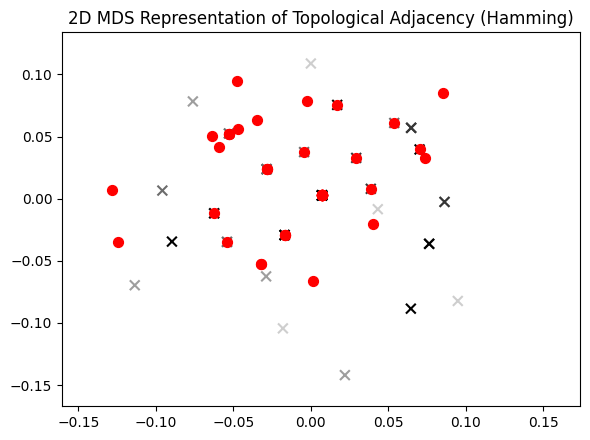

In [ ]:
suffix = "aux_var-31-6"
ent, dist_hist, dist_topo_hamming = np.load("K:\CET\Resultats\Analysis of results\ent_"+suffix+".npy"),np.load("K:\CET\Resultats\Analysis of results\dist_hist_"+suffix+".npy"), np.load("K:\CET\Resultats\Analysis of results\dist_topo_hamming_"+suffix+".npy")
plot_topological_adjacency(dist_topo_hamming, nsets=31, ngroups=6, referenceIsPresent=True, show=False, plot_size_factor=0.75)